The nb is copy of [walk with fastai](https://walkwithfastai.com/revisited/multilabel.html).

In [1]:
!pip install -q nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 786.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.6 MB/s eta 0:00:00


In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.PLANET_SAMPLE)
path.ls()

(#2) [Path('/root/.fastai/data/planet_sample/train'),Path('/root/.fastai/data/planet_sample/labels.csv')]

## Explore labels

In [3]:
df = pd.read_csv(path/'labels.csv')
df.head()

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road


In [4]:
tags = df.tags.values
type(tags), tags.shape

(numpy.ndarray, (1000,))

In [5]:
tags = [i.split(' ')  for i in tags]
all_tags = [i for tag in tags for i in tag ]
len(all_tags)

2899

In [6]:
labels = set(all_tags)
len(labels)

17

In [7]:
labels_dict = {}
for i in labels:
  labels_dict[i] = all_tags.count(i)
labels_dict

{'blooming': 9,
 'agriculture': 318,
 'slash_burn': 6,
 'water': 169,
 'cloudy': 50,
 'habitation': 93,
 'selective_logging': 8,
 'blow_down': 1,
 'cultivation': 124,
 'primary': 934,
 'conventional_mine': 2,
 'bare_ground': 19,
 'clear': 701,
 'haze': 55,
 'road': 209,
 'artisinal_mine': 7,
 'partly_cloudy': 194}

In [8]:
df['tags'].str.contains('blow_down').sum()

1

In [9]:
for i, count in labels_dict.items():
  #print(i, count)
  if count < 10:
    df = df[df['tags'].str.contains(i) == False]

In [10]:
df.shape

(968, 2)

## Data processing

In [11]:
(path/'train').ls()

(#1000) [Path('/root/.fastai/data/planet_sample/train/train_33138.jpg'),Path('/root/.fastai/data/planet_sample/train/train_37260.jpg'),Path('/root/.fastai/data/planet_sample/train/train_4514.jpg'),Path('/root/.fastai/data/planet_sample/train/train_6866.jpg'),Path('/root/.fastai/data/planet_sample/train/train_35212.jpg'),Path('/root/.fastai/data/planet_sample/train/train_11062.jpg'),Path('/root/.fastai/data/planet_sample/train/train_1364.jpg'),Path('/root/.fastai/data/planet_sample/train/train_3362.jpg'),Path('/root/.fastai/data/planet_sample/train/train_26436.jpg'),Path('/root/.fastai/data/planet_sample/train/train_2286.jpg')...]

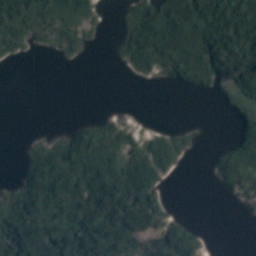

In [12]:
im = PILImage.create((path/'train').ls()[0])
im

In [13]:
im.shape

(256, 256)

In [14]:
get_x = ColReader(0, pref=f'{path}/train/', suff=".jpg")
get_y = ColReader(1, label_delim=" ")

In [15]:
tfms = [
    [get_x, PILImage.create],
    [
        get_y,
        MultiCategorize(vocab=labels_dict.keys()),
        OneHotEncode(c=len(labels_dict.keys()))
    ]
]

In [16]:
dsets = Datasets(df, tfms=tfms, splits=RandomSplitter(valid_pct=0.2)(df))

In [17]:
dsets.train[0]

(PILImage mode=RGB size=256x256,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
                      0., 0.]))

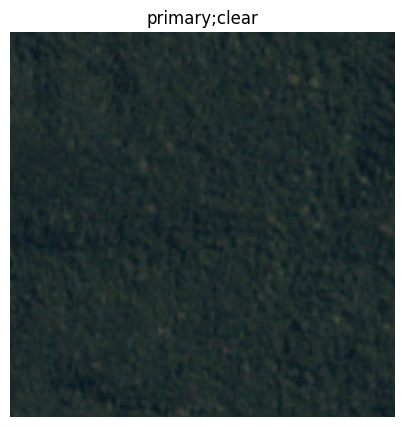

In [18]:
show_at(dsets.train, 0);

In [19]:
batch_tfms = [
    IntToFloatTensor(),
    *aug_transforms(
        flip_vert=True,
        max_lighting=0.1,
        max_zoom=1.05,
        max_warp=0.
    ),
    Normalize.from_stats(*imagenet_stats)
]


In [20]:
dls = dsets.dataloaders(
    after_item=[ToTensor],
    after_batch=batch_tfms
)

In [21]:
dls.device

device(type='cuda', index=0)

In [22]:
learn = vision_learner(dls, resnet34, metrics=[accuracy_multi])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 121MB/s]


In [23]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=17, bias=False)
)

In [24]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [25]:
learn.loss_func.thresh

0.5

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


SuggestedLRs(valley=0.0012022644514217973)

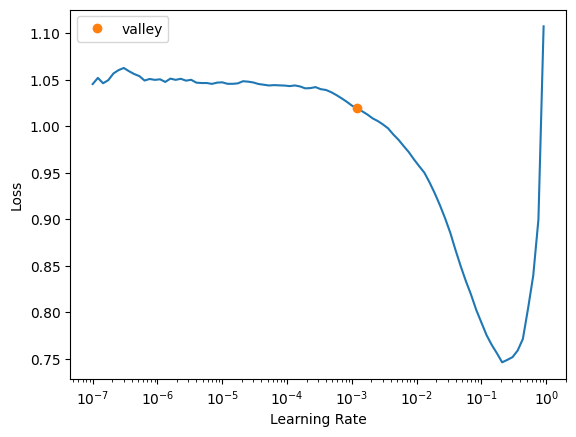

In [26]:
learn.lr_find()

In [27]:
learn.fit_one_cycle(1, slice(2e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.952941,0.695616,0.621457,00:05


In [28]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(2e-3/2.6**4, 2e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.851263,0.674106,0.660469,00:05
1,0.785518,0.660589,0.707102,00:05
2,0.713508,0.526896,0.799451,00:05
3,0.649266,0.424628,0.881439,00:05
4,0.603594,0.405604,0.897592,00:05


# CNN experiments

In [29]:
def conv(ni, nf, ks=3, act=True, stride=2):
    layer = [nn.Conv2d(ni, nf, padding=ks//2, kernel_size=ks, stride=stride)]
    layer.append(nn.BatchNorm2d(nf))
    if act:
        layer.append(nn.ReLU())

    return nn.Sequential(*layer)

In [30]:
def model_256():
    return sequential(
        conv(3, 8, ks=5),   # 128 * 128
        conv(8, 16),        # 64 * 64
        conv(16, 32),       # 32 * 32
        conv(32, 64),       # 16 * 16
        conv(64, 128),      # 8 * 8
        conv(128, 256),     # 4 * 4
        Flatten(),
        nn.Linear(256 * 4 * 4, 512),
        nn.Dropout(p=0.20),
        nn.Linear(512, 64),
        nn.Dropout(p=0.20),
        nn.Linear(64, dls.c),
    )

In [31]:
from fastai.callback.hook import *
def get_learner(model_func, epoch=1, lr=0.03):
    learner = Learner(dls,
                      model_func,
                      loss_func=BCEWithLogitsLossFlat(),
                      metrics=[accuracy_multi],

                     )
    learner.fit_one_cycle(epoch, lr)
    #print(learner.summary())
    return learner

In [32]:
learn1 = get_learner(model_func=model_256(), epoch=12)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.396615,1.225845,0.883572,00:03
1,0.430061,6.899693,0.811033,00:02
2,0.632709,276.187988,0.779336,00:02
3,1.811280,197.396027,0.873209,00:02
4,1.555084,16.876644,0.883267,00:02
5,1.280429,0.693013,0.900640,00:02
6,1.037490,0.269821,0.914355,00:02
7,0.861892,0.269904,0.912222,00:02
8,0.722872,0.264904,0.914965,00:02
9,0.619014,0.258185,0.914965,00:03


In [33]:
def conv(ni, nf, ks=3, act=True, stride=2):
    layer = [nn.Conv2d(ni, nf, padding=ks//2, kernel_size=ks, stride=stride)]
    if act:
        layer.append(nn.ReLU())
    layer.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layer)
learn2 = get_learner(model_func=model_256(), epoch=12, lr=0.1)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.507194,159.873138,0.871990,00:02
1,24.000790,263008.812500,0.541603,00:02
2,240.951248,10745.524414,0.723560,00:03
3,1368.016724,12310.568359,0.851570,00:02
4,3212.269287,45203.703125,0.580616,00:02
5,3763.213135,4960.969727,0.871076,00:02
6,3258.127197,892.356079,0.901554,00:02
7,2585.114990,207.331543,0.878086,00:03
8,2003.465210,94.001297,0.889973,00:02
9,1558.447876,70.109566,0.914660,00:02


In [34]:
def conv(ni, nf, ks=3, act=True, stride=2):
    layer = [nn.Conv2d(ni, nf, padding=ks//2, kernel_size=ks, stride=stride)]
    layer.append(nn.BatchNorm2d(nf))
    if act:
        layer.append(nn.ReLU())

    return nn.Sequential(*layer)
def model_256_avg():
    return sequential(
        conv(3, 8, ks=5),   # 128 * 128
        conv(8, 16),        # 64 * 64
        conv(16, 32),       # 32 * 32
        conv(32, 64),       # 16 * 16
        conv(64, 128),      # 8 * 8
        conv(128, 256),     # 4 * 4
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, 512),
        nn.Dropout(p=0.20),
        nn.Linear(512, 64),
        nn.Dropout(p=0.20),
        nn.Linear(64, dls.c),
    )
learn3 = get_learner(model_func=model_256_avg(), epoch=12, lr=0.01)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.461923,0.317553,0.916489,00:03
1,0.365474,1.904516,0.915574,00:02
2,0.316195,0.552824,0.849741,00:02
3,0.287450,0.236479,0.911917,00:02
4,0.266754,0.217077,0.921975,00:02
5,0.253332,0.200363,0.919232,00:02
6,0.242241,0.198436,0.918622,00:02
7,0.233603,0.196650,0.923194,00:02
8,0.226149,0.194589,0.921670,00:02
9,0.220526,0.192818,0.926852,00:03


In [35]:
def block(ni, nf): return ConvLayer(ni, nf, stride=2)
def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))

learn4 = get_learner(model_func=get_model(), epoch=12, lr=0.01)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.545325,0.343219,0.909479,00:02
1,0.380445,0.331613,0.913136,00:02
2,0.307800,0.265904,0.905212,00:03
3,0.271301,0.212004,0.914965,00:02
4,0.250230,0.203423,0.914355,00:02
5,0.237279,0.200279,0.918013,00:02
6,0.227108,0.201273,0.918927,00:02
7,0.218305,0.187108,0.922889,00:03
8,0.212201,0.510457,0.800671,00:02
9,0.206997,0.188417,0.921975,00:02


In [36]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero))

class ResBlock(Module):
  def __init__(self, ni, nf, stride=1):
    self.conv = _conv_block(ni, nf, stride)
    self.idconv = noop if ni == nf else ConvLayer(ni, nf, 1, act_cls=None)
    self.pool = noop if stride == 1 else nn.AvgPool2d(2, ceil_mode=True)

  def forward(self, x):
    return F.relu(self.conv(x) + self.idconv(self.pool(x))) # devide the image by 2*2 using AvgPool2d then idconv

def block(ni, nf): return ResBlock(ni, nf, 2)

learn5 = get_learner(model_func=get_model(), epoch=12, lr=0.01)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.521010,0.557415,0.914965,00:03
1,0.368602,0.219873,0.917098,00:02
2,0.302384,0.206044,0.915879,00:02
3,0.268511,0.253437,0.903688,00:02
4,0.248861,0.208929,0.914051,00:03
5,0.235433,0.196243,0.919842,00:02
6,0.226356,0.194860,0.922889,00:02
7,0.218157,0.197250,0.924413,00:02
8,0.211775,0.195376,0.921365,00:03
9,0.206577,0.194194,0.920756,00:02


In [37]:
def block(ni, nf):
  return nn.Sequential(
    ResBlock(ni, nf, 2),
    ResBlock(nf, nf))

learn6 = get_learner(model_func=get_model(), epoch=12, lr=0.01)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.521418,0.538120,0.914965,00:03
1,0.366455,0.220466,0.918622,00:03
2,0.303116,0.206914,0.919537,00:03
3,0.270787,0.213459,0.921061,00:03
4,0.250333,0.197769,0.920451,00:05
5,0.236205,0.196907,0.918318,00:04
6,0.225643,0.201301,0.920756,00:05
7,0.217883,0.191754,0.922280,00:03
8,0.211436,0.193862,0.921670,00:03
9,0.205599,0.194235,0.922585,00:03


In [38]:
def _resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], 3, stride = 2 if i==0 else 1)
            for i in range(len(sizes)-1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(3,32,32,64)
        self.block_szs = [64, 64, 128, 256, 512]
        for i in range(1,5): self.block_szs[i] *= expansion
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks,
                         nn.AdaptiveAvgPool2d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))

    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in,ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)
        ])

rn = ResNet(dls.c, [2,2,2,2])
learn7 = get_learner(model_func=rn, epoch=20, lr=0.01)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.486636,0.533766,0.917098,00:05
1,0.348156,0.207117,0.923194,00:05
2,0.288211,0.248862,0.910698,00:05
3,0.261565,0.343813,0.870466,00:05
4,0.244205,0.239888,0.912222,00:05
5,0.233014,0.272683,0.875952,00:05
6,0.225874,0.203047,0.918622,00:05
7,0.218750,0.207679,0.914355,00:05
8,0.211510,0.180035,0.926242,00:05
9,0.206630,0.211858,0.913441,00:05


In [32]:
x, y = dls.one_batch()

In [33]:
avg = nn.AvgPool2d(2, ceil_mode=True)

In [35]:
x.shape

torch.Size([64, 3, 256, 256])

In [34]:
avg(x).shape

torch.Size([64, 3, 128, 128])

new Resnet which trained with 20 epoch beats transfer learnig resnet18 arch